# Time Series Temperature Prediction

Richard Kaldenhoven

Version 1: March 11, 2021

## 1. Problem Definition

The objective of this notebook is to develop a machine learning model that can predict the future temperature based on past weather information. The model will be a Recurrent Neural Network developed using the Keras deep learning framework. The weather timeseries dataset used here is from the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany (https://www.bgc-jena.mpg.de/wetter/).


## 2. Measure of Success

The model performance metric chosen for this problem is the mean absolute error (MAE) between predicted temperatures and the actual temperatures:

$$
MAE = \frac{\sum |y_{predicted} - y_{actual}|}{n}
$$

where _n_ is the number of samples. A benefit of the MAE is that it is expressed in the same units as the data used.


## 3. Model Evaluation Protocol

Models will be evaluated based on a 70%/20%/10% train/validation/test split of the data, where models will be trained on the training data, and then evaluated on the validation data during model development. Once a final model configuration has been found, it will be re-trained on the combined training and validation sets (the "complete" training set), and then evaluated on the test set.


## 4. Data Preparation

The dataset used in this problem was downloaded from: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip . The weather data is limited to dates ranging from 2009-2016. The dataset contains the following columns:

| Column          | Description                             |
|-----------------|-----------------------------------------|
| Date Time       | Time and Data of weather data recording |
| p (mbar)        | Pressure in mbar                        |
| T (degC)        | Temperature in Celsius                  |
| Tpot (K)        | Temperature in Kelvin                   |
| Tdew (degC)     | Dew point in Celsius                    |
| rh (%)          | Relative Humidity percentage            |
| VPmax (mbar)    | Saturation vapor pressure               |
| VPdef (mbar)    | Vapor pressure deficit                  |
| sh (g/kg)       | Specific Humidity                       |
| H2OC (mmol/mol) | Water vapor concentration               |
| rho (g/m**3)    | Air density                             |
| wv (m/s)        | Wind speed                              |
| max. wv (m/s)   | Maximum wind speed                      |
| wd (deg)        | Wind direction in degrees               |

Data Preparation for this problem consists of the following steps:
1. Exploratory Data Analysis - explore dataset features
2. Feature Engineering - modify features for use in a machine learning model
3. Data Standardization - standardize data for use in a machine learning model
4. Data Generation - develop method of generating time series sequences that can be fed to a machine learning model


### 4.1 Exploratory Data Analysis



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The following code loads the data into a pandas DataFrame and previews the dataset:

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')

In [3]:
df.head(12)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


From the preview of the dataset, it is observed that samples are recorded every ten minutes. To simplify the problem, the data will be subsampled every 6th record, starting at the 6th record (in order to start on a new hour) to create a new DataFrame with one sample every hour.

In [4]:
# sample every 6 records starting at 6th record (start at 1 AM because the first 5 records are not a full hour). 
# 10 minutes x 6 = 1 hour
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70075 entries, 5 to 420449
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70075 non-null  object 
 1   p (mbar)         70075 non-null  float64
 2   T (degC)         70075 non-null  float64
 3   Tpot (K)         70075 non-null  float64
 4   Tdew (degC)      70075 non-null  float64
 5   rh (%)           70075 non-null  float64
 6   VPmax (mbar)     70075 non-null  float64
 7   VPact (mbar)     70075 non-null  float64
 8   VPdef (mbar)     70075 non-null  float64
 9   sh (g/kg)        70075 non-null  float64
 10  H2OC (mmol/mol)  70075 non-null  float64
 11  rho (g/m**3)     70075 non-null  float64
 12  wv (m/s)         70075 non-null  float64
 13  max. wv (m/s)    70075 non-null  float64
 14  wd (deg)         70075 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


The data has no missing values. Descriptive statistics of the data are generated with the `describe()` function:

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70075.0,989.212743,8.360039,913.60,984.200,989.57,994.730,1015.30
T (degC),70075.0,9.448744,8.424157,-22.76,3.355,9.41,15.480,37.28
Tpot (K),70075.0,283.491357,8.505250,250.85,277.440,283.46,289.530,311.21
Tdew (degC),70075.0,4.954871,6.730648,-24.80,0.240,5.21,10.070,23.06
rh (%),70075.0,76.010481,16.475518,13.88,65.215,79.30,89.400,100.00
VPmax (mbar),70075.0,13.575524,7.741167,0.97,7.770,11.82,17.610,63.77
VPact (mbar),70075.0,9.533114,4.184117,0.81,6.220,8.86,12.360,28.25
VPdef (mbar),70075.0,4.042332,4.898866,0.00,0.870,2.19,5.300,46.01
sh (g/kg),70075.0,6.022018,2.656094,0.51,3.920,5.59,7.810,18.07
H2OC (mmol/mol),70075.0,9.639577,4.235312,0.81,6.280,8.96,12.490,28.74


From the statistics, there do not appear to be any outliers within the data, but plotting the data will make it easier for outliers to be identified.

In [7]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

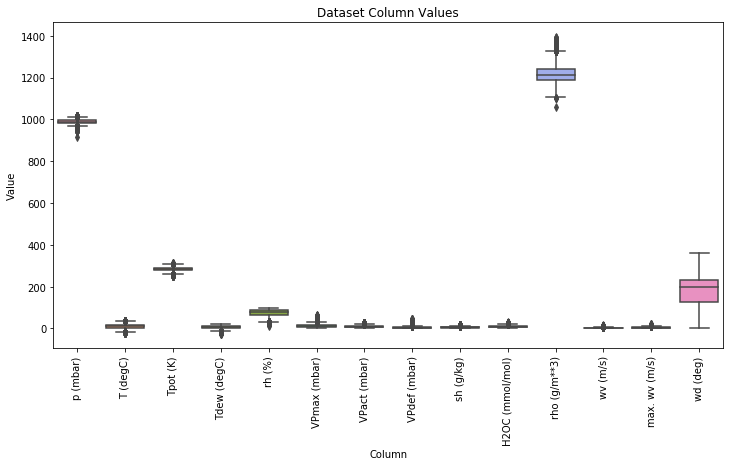

In [8]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Value')
plt.title('Dataset Column Values');

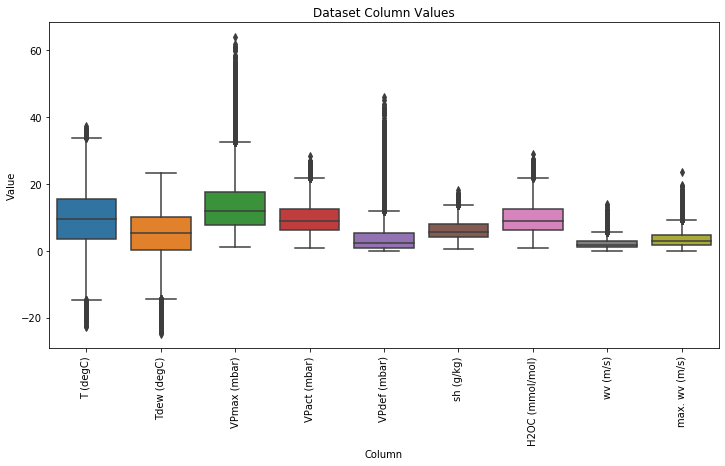

In [9]:
plt.figure(figsize=(12,6))
g = sns.boxplot(data=df.drop(['p (mbar)','Tpot (K)','rh (%)','rho (g/m**3)','wd (deg)'], axis=1))
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Value')
plt.title('Dataset Column Values');

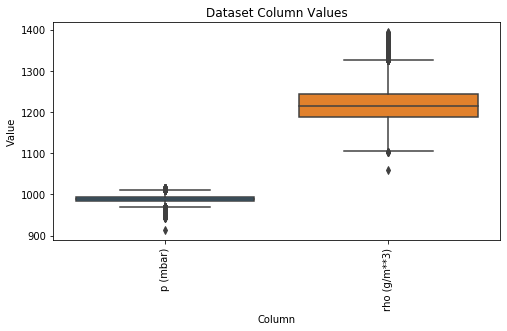

In [10]:
plt.figure(figsize=(8,4))
g = sns.boxplot(data=df[['p (mbar)','rho (g/m**3)']])
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Value')
plt.title('Dataset Column Values');

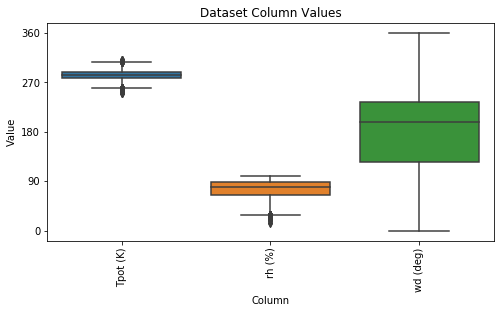

In [11]:
plt.figure(figsize=(8,4))
g = sns.boxplot(data=df[['Tpot (K)','rh (%)','wd (deg)']])
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Value')
plt.title('Dataset Column Values')
plt.yticks([0, 90, 180, 270, 360]);

Plots of the data show that column values can be in very different ranges, meaning that prior to using in a machine learning model, the data should be standardized, which is covered in Section 4.3.

Given that the data is for weather, it is expected that the data varies in a cyclical fashion over time, both over the course of a 24 hour period (day vs. night) and over a year (changes through the seasons). To investigate the variation in data over time, the temperature, pressure, and air density columns are plotted.

In [12]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

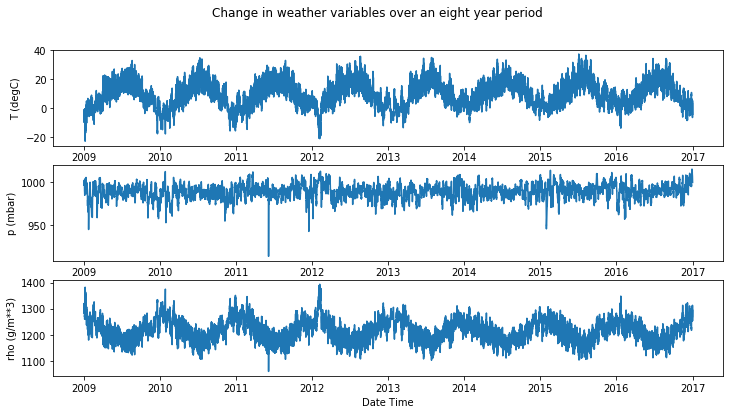

In [13]:
plt.subplots(sharex=True, figsize=(12,6))

plt.subplot(3,1,1)
sns.lineplot(data=df, x='Date Time', y='T (degC)')

plt.subplot(3,1,2)
sns.lineplot(data=df, x='Date Time', y='p (mbar)')

plt.subplot(3,1,3)
sns.lineplot(data=df, x='Date Time', y='rho (g/m**3)')

plt.suptitle('Change in weather variables over an eight year period');

As expected, there is a cyclical variation in the weather data. The same data is plotted again, however only for the first month to illustrate the day to day variation.

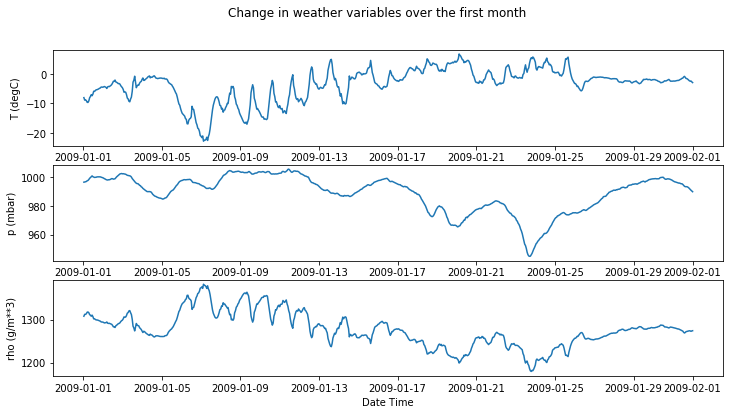

In [14]:
plt.subplots(sharex=True, figsize=(12,6))

plt.subplot(3,1,1)
sns.lineplot(data=df[:744], x='Date Time', y='T (degC)')

plt.subplot(3,1,2)
sns.lineplot(data=df[:744], x='Date Time', y='p (mbar)')

plt.subplot(3,1,3)
sns.lineplot(data=df[:744], x='Date Time', y='rho (g/m**3)')

plt.suptitle('Change in weather variables over the first month');

### 4.2 Feature Engineering

Several of the columns, or features, of the data are not in a form that is the most useful for a machine learning model. The `wd (deg)` feature is slightly confusing, as 0 degrees and 360 degrees should be close in values. A more useful representation of the wind direction can be obtained by combining the wind direction and wind velocity features (`wv (m/s)` and `max. wv (m/s)`) into new features for the x and y components of the wind velocity. 

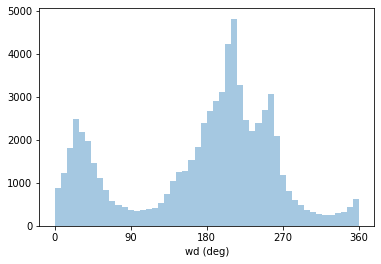

In [15]:
sns.distplot(df['wd (deg)'], kde=False)
plt.xticks(np.arange(0,360+1,90));

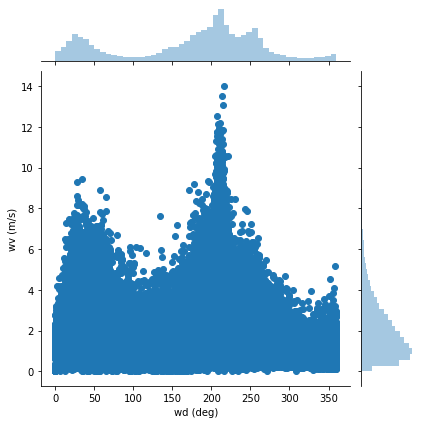

In [16]:
sns.jointplot(x=df['wd (deg)'], y=df['wv (m/s)'])

In [17]:
# x component of wind velocity
df['wd x'] = df['wv (m/s)'] * np.cos(df['wd (deg)'] * np.pi / 180)

# y component of wind velocity
df['wd y'] = df['wv (m/s)'] * np.sin(df['wd (deg)'] * np.pi / 180)

# x component of max wind velocity
df['max wd x'] = df['max. wv (m/s)'] * np.cos(df['wd (deg)'] * np.pi / 180)

# y component of max wind velocity
df['max wd y'] = df['max. wv (m/s)'] * np.sin(df['wd (deg)'] * np.pi / 180)


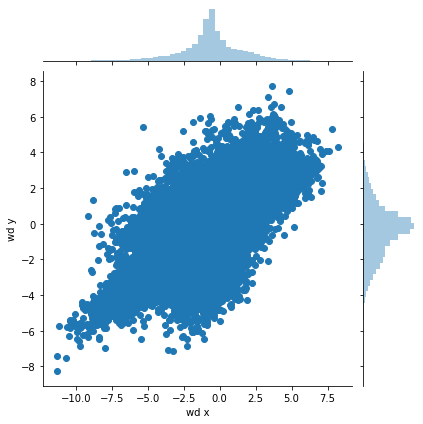

In [18]:
sns.jointplot(x=df['wd x'], y=df['wd y'])

The `wv (m/s)`, `wd (deg)` and `max. wv (m/s)` have been replaced by the `wd x`, `wd y`, `max wd x` and `max wd y` features, so are removed from the dataset.

In [19]:
df = df.drop(['wv (m/s)', 'wd (deg)', 'max. wv (m/s)'], axis=1)

The `Date Time` feature is more useful in the form of a time of day signal rather than in string form. The time of day is represented by two values, `time of day sin` and `time of day cos`. Since both functions are periodic, a particular signal value can represent two times (see plot below), so both a sin and cos function are used in combination to represent the time. A time of day signal matches with the cyclical variation in weather features over the course of a day.

`time of year sin` and `time of year cos` features are also created, matching seasonal variations in weather.

The following code first converts `Date Time` to a temporary `timestamp` feature which contains the time of day in seconds. Then, `timestamp` is converted to a signal.

In [20]:
import datetime

df['timestamp'] = df['Date Time'].map(datetime.datetime.timestamp)

seconds_per_day = 24*60*60
seconds_per_year = 365.25 * seconds_per_day

df['time of day sin'] = np.sin(df['timestamp'] * (2 * np.pi / seconds_per_day))
df['time of day cos'] = np.cos(df['timestamp'] * (2 * np.pi / seconds_per_day))

df['time of year sin'] = np.sin(df['timestamp'] * (2 * np.pi / seconds_per_year))
df['time of year cos'] = np.cos(df['timestamp'] * (2 * np.pi / seconds_per_year))

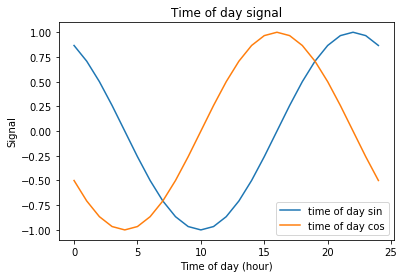

In [21]:
plt.figure()
plt.plot(np.array(df['time of day sin'])[:25], label='time of day sin')
plt.plot(np.array(df['time of day cos'])[:25], label='time of day cos')
plt.legend()
plt.xlabel('Time of day (hour)')
plt.ylabel('Signal')
plt.title('Time of day signal');

The plot below shows how the pair of sin and cos signals represents the time of day. Since the dataset has one point every hour, there are 24 possible times during the day, shown by the 24 points on the plot. Each point is represented by a pair of `time of day sin` and `time of day cos` values.

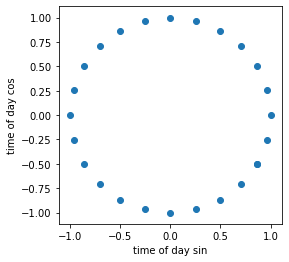

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(x=np.array(df['time of day sin'])[:25], y=np.array(df['time of day cos'])[:25])
plt.xlabel('time of day sin')
plt.ylabel('time of day cos');

The temporary `timestamp` and now redundant `Date Time` column are dropped from the data.

In [23]:
df = df.drop(['timestamp','Date Time'], axis=1)

After feature engineering, the data is now in the following form:

In [296]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wd x,wd y,max wd x,max wd y,time of day sin,time of day cos,time of year sin,time of year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,8.660254e-01,-0.500000,0.010035,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,7.071068e-01,-0.707107,0.010751,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,5.000000e-01,-0.866025,0.011468,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,2.588190e-01,-0.965926,0.012185,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,6.903299e-12,-1.000000,0.012901,0.999917


In [24]:
df.shape

(70075, 19)

### 4.3 Data Standardization

The dataset contains features that have values in different ranges, so the dataset must be standardized in order to not have one feature dominate the others. Standardization of each feature is achieved by subtracting its mean and dividing by its standard deviation, so that each feature has a mean of 0 and a standard deviation of 1. 

In this case, the approach of subtracting the mean and dividing by the standard deviation is technically incorrect because both statistics are calculated over an entire dataset, meaning that values in the past are influenced by values from the future. Since this problem deals with using past data to predict the future, such an approach introduces error but is used here for simplicity.

The following code splits the dataset into train, validation and test sets in a 70%/20%/10% ratio. The mean and standard deviation of the features is calculated on the training set only, to avoid introducing information from the validation and test sets into the training set, and then the three datasets are standardized.

Data is not shuffled in order to preserve the order of time present in the data. The validation set contains data occuring after the training set, and similarily the test set contains data occuring after the training and validation sets.

In [25]:
num_samples = len(df)
num_train_samples = int(0.7 * num_samples)
num_val_samples = int(0.2 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples

print('num_samples: ', num_samples)
print('num_train_samples: ', num_train_samples)
print('num_val_samples: ', num_val_samples)
print('num_test_samples: ', num_test_samples)

df_train = df[:num_train_samples]
df_val = df[num_train_samples: num_train_samples + num_val_samples]
df_test = df[num_train_samples + num_val_samples:]

print('\n')
print('length df_train: ', len(df_train))
print('length df_val: ', len(df_val))
print('length df_test: ', len(df_test))

num_samples:  70075
num_train_samples:  49052
num_val_samples:  14015
num_test_samples:  7008


length df_train:  49052
length df_val:  14015
length df_test:  7008


In [26]:
df_train_mean = df_train.mean()
df_train_std = df_train.std()

df_train = (df_train - df_train_mean) / df_train_std
df_val = (df_val - df_train_mean) / df_train_std
df_test = (df_test - df_train_mean) / df_train_std

In [27]:
print('Mean T in df_train: ', df_train_mean[1])
print('Std dev of T in df_train: ', df_train_std[1])

Mean T in df_train:  9.106124724781841
Std dev of T in df_train:  8.654671040774211


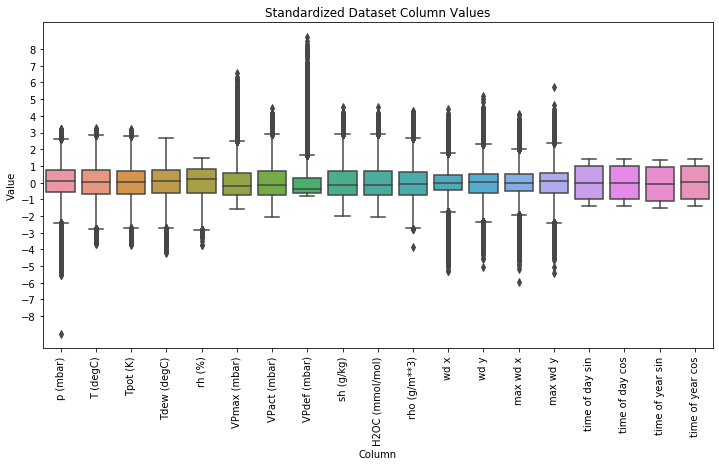

In [28]:
df_std = (df - df_train_mean) / df_train_std

plt.figure(figsize=(12,6))
sns.boxplot(data=df_std)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Value')
plt.yticks(np.arange(-8,9,1))
plt.title('Standardized Dataset Column Values');

### 4.4 Data Generation

The final step in data preparation is to generate sequences of data that can be used in a machine learning model. First, the values from the train, validation, and test sets are stored in numpy arrays:

In [29]:
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

Next, in order to predict the temperature in the future, past weather information will be used. The temperature prediction problem is formulated as "Given weather information for the past five days, what is the temperature one day in the future?"

The length of time in the past is defined as the `input_length`. The delay in time from the end of `input_length` to the time that a prediction is made is defined as the `offset`. A sequence of weather data from the past, containing `input_length` timesteps, has a corresponding temperature that is `offset` timesteps in the future. The sequence of weather data is the sample, and its corresponding temperature is the target that a machine learning model will learn to predict.

The following code is for a generator function that loops endlessly through the specified dataset (`data`), yielding pairs of `samples` and `targets`. The `batch_size` parameter is the number of samples per batch. The `step` parameter is the frequency at which data is sampled, and is set to a default of 1 as the data is already in 1 hour steps.

The `T (degC)` feature is still included in `samples`, meaning that the hourly temperature will still be input to a machine learning model, even though the temperature is the target feature to predict.

In [30]:
def data_generator(data, input_length, offset, batch_size, step=1):
    max_index = len(data)
    min_index = 0
    
    i = min_index + input_length
    
    while True:
        if i + batch_size >= max_index:
            i = min_index + input_length
            
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        
        # samples shape (number of samples per batch, input length, number of features)
        samples = np.zeros((len(rows), input_length // step, data.shape[-1]))
        # targets shape (number of samples per batch, )
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - input_length, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + offset][1] # 1 is index for 'T (degC)' column
            
        yield samples, targets

The following code establishes the parameters for the generator function: an `input_length` of 120 hours, an `offset` of 24 hours, a `step` of 1, and a `batch_size` of 1. Then, three generators are created for the train, validation, and test datasets. These generator variables will be used as input to a machine learning model, and will generate batches of `samples` and `targets` that the model will be trained on. Since the generator functions loop endlessly, the number of steps that it takes to loop through a dataset is necessary to let the function know when to stop. The number of steps for the validation set (`val_steps`) and test set (`test_steps`) are also calculated below.

In [31]:
input_length = 24 * 5              # 120 hours = 5 days
offset = 24                         # predict Temp 24 hours in future
step = 1                            # sampled at frequency of 1 hour

batch_size = 128                    # 128 samples per batch

train_gen = data_generator(data=train_data, 
                           input_length=input_length, 
                           offset=offset, 
                           batch_size=batch_size, 
                           step=step)

val_gen = data_generator(data=val_data, 
                           input_length=input_length, 
                           offset=offset, 
                           batch_size=batch_size, 
                           step=step)

test_gen = data_generator(data=test_data, 
                           input_length=input_length, 
                           offset=offset, 
                           batch_size=batch_size, 
                           step=step)

val_steps = (num_val_samples - input_length) // batch_size
test_steps = (num_test_samples - input_length) // batch_size

In [32]:
print('val_steps = ', val_steps)
print('test_steps = ', test_steps)

val_steps =  108
test_steps =  53


As an example, the following code shows the shape and some of the values generated by `train_gen`:

In [33]:
samples, targets = next(train_gen)
print('Samples shape: ', samples.shape)
print('Targets shape: ', targets.shape)

Samples shape:  (128, 120, 19)
Targets shape:  (128,)


In [34]:
samples[0][0]

array([ 0.94522684, -1.98229657, -2.04171101, -1.91893139,  1.117172  ,
       -1.30268364, -1.47736115, -0.79038499, -1.48007428, -1.4827348 ,
        2.21833972,  0.19345932,  0.22120858,  0.11120678,  0.21798513,
        1.22498295, -0.70695282, -0.06157987,  1.42823792])

In [35]:
targets[0]

-3.5433033306877224

To check that the `data_generator` function is working as expected, a small sample dataset is created and then a batch of `samples` and `targets` is created:

In [36]:
sample_data = train_data[:13]

sample_gen = data_generator(data=sample_data, 
                           input_length=10, 
                           offset=1, 
                           batch_size=1, 
                           step=1)

print('Sample features at hour 0: ' + '\n' + str(next(sample_gen)[0][0][0]))
print('Look up features at hour 0: ' + '\n' + str(sample_data[0]))
print('\n')
print('Target temperature, at hour 12: ' + '\n' + str(next(sample_gen)[1][0]))
print('Look up features at hour 12: ' + '\n' + str(sample_data[12]))
print('Look up temperature at hour 12: ' + '\n' + str(sample_data[12][1]))

Sample features at hour 0: 
[ 0.94522684 -1.98229657 -2.04171101 -1.91893139  1.117172   -1.30268364
 -1.47736115 -0.79038499 -1.48007428 -1.4827348   2.21833972  0.19345932
  0.22120858  0.11120678  0.21798513  1.22498295 -0.70695282 -0.06157987
  1.42823792]
Look up features at hour 0: 
[ 0.94522684 -1.98229657 -2.04171101 -1.91893139  1.117172   -1.30268364
 -1.47736115 -0.79038499 -1.48007428 -1.4827348   2.21833972  0.19345932
  0.22120858  0.11120678  0.21798513  1.22498295 -0.70695282 -0.06157987
  1.42823792]


Target temperature, at hour 12: 
-1.7327203603847603
Look up features at hour 12: 
[ 1.37061129 -1.73272036 -1.82507942 -1.72957987  0.76684335 -1.22470397
 -1.39654164 -0.7364204  -1.40143424 -1.40524623  2.06866986  0.01436542
  0.20439236 -0.08873068  0.21022557 -1.22447649  0.70724947 -0.04930512
  1.42806459]
Look up temperature at hour 12: 
-1.7327203603847603


The sample features at hour 0 is generated from the function, and matches the data looked up from the sample dataset. The target temperature corresponding to the features at hour 0 correctly matches the value in the sample dataset at hour 12, so it appears that the `data_generator` function is working correctly.

## 5. Baseline Models

Prior to investing effort into experimenting with more complicated models, it is worth developing a baseline model to act as a "starting point" to put future results into perspective. For this problem two baselines are created, a non-machine-learning baseline and machine learning baseline, to help evaluate whether further efforts with more complicated models provide any additional benefit.

### 5.1 Non-machine-learning baseline

To start, a simple model to predict the temperature 1 hour in the future would be to simply assume that the temperature is equal to the current temperature, as shown in the following code:

In [37]:
# Naive baseline model: temperature 1 hour in the future is equal to the current temperature

batch_maes = []
for step in range(val_steps):
    samples, targets = next(val_gen)
    
    # array slicing [all samples in batch, features at last hour in batch (current temperature), temperature index]
    predictions = samples[:, -1, 1] 
    
    step_mae = np.mean(np.abs(predictions - targets))
    batch_maes.append(step_mae)
mae = np.mean(batch_maes)
print('Naive baseline MAE: ', mae)

Naive baseline MAE:  0.3188047259030614


The model gives a MAE of 0.3188, which is expressed in standardized degrees Celsius, since the data has been standardized.

### 5.2 Machine learning baseline

To set a machine learning baseline, a simple deep learning model consisting of a densely connected layer is created:

In [38]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Flatten(input_shape=(input_length, train_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                72992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 73,025
Trainable params: 73,025
Non-trainable params: 0
_________________________________________________________________


For model training it is necessary to define the `steps_per_epoch`, or the number of steps that `train_gen` must take to go through one pass of the training data:

In [39]:
steps_per_epoch = (num_train_samples - input_length) // batch_size
print('steps_per_epoch = ', steps_per_epoch)

steps_per_epoch =  382


The following code creates the function `model_compile_fit`, which combines the Keras `compile` and `fit` functions. The mean square error loss function is used, and the MAE metric is set to be monitored.

An `EarlyStopping` callback is added to cut down on unnecessary training time (training time without a decrease in the loss function). The `patience` and `min_delta` parameters have been set after some experimentation to allow the model training to not be stopped too early. 

In [40]:
from keras.callbacks import EarlyStopping

def model_compile_fit(model, data, steps_per_epoch, epochs, validation_data, validation_steps, 
                      early_stopping=True, patience=10, min_delta=0.2):
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    if early_stopping == True:
        early_stopping_call = EarlyStopping(monitor='val_loss', mode='min', patience=patience, min_delta=min_delta)
        
        history = model.fit(data, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=epochs, 
                            validation_data=validation_data, 
                            validation_steps=validation_steps, 
                            callbacks=[early_stopping_call])
    else:
    
        history = model.fit(data, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=epochs, 
                            validation_data=validation_data, 
                            validation_steps=validation_steps)
    
    return history

`model_compile_fit` is now used to begin training:

In [41]:
history = model_compile_fit(model=model, 
                            data=train_gen, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=20, 
                            validation_data=val_gen, 
                            validation_steps=val_steps,
                            early_stopping=True,
                            patience=10, 
                            min_delta=0.2)

Epoch 1/20
382/382 [==============================] - 5s 14ms/step - loss: 26.5993 - mae: 3.7853 - val_loss: 72.1303 - val_mae: 6.7791
Epoch 2/20
382/382 [==============================] - 6s 16ms/step - loss: 20.9831 - mae: 3.1884 - val_loss: 6.2394 - val_mae: 1.8463
Epoch 3/20
382/382 [==============================] - 6s 16ms/step - loss: 1.8036 - mae: 0.9915 - val_loss: 0.6880 - val_mae: 0.6425
Epoch 4/20
382/382 [==============================] - 5s 13ms/step - loss: 0.4913 - mae: 0.5467 - val_loss: 0.9094 - val_mae: 0.7534
Epoch 5/20
382/382 [==============================] - 5s 13ms/step - loss: 0.8015 - mae: 0.6714 - val_loss: 0.5611 - val_mae: 0.5813
Epoch 6/20
382/382 [==============================] - 4s 12ms/step - loss: 0.5190 - mae: 0.5330 - val_loss: 1.7360 - val_mae: 1.0096
Epoch 7/20
382/382 [==============================] - 4s 11ms/step - loss: 6.9051 - mae: 1.8793 - val_loss: 11.5096 - val_mae: 2.7877
Epoch 8/20
382/382 [==============================] - 4s 11ms/ste

The function `create_val_plot` is defined below to create loss and MAE plots for model training:

In [42]:
def create_val_plot(model_history):
        
    model_history = model_history.history

    # Training and validation loss plot
    loss_values = model_history['loss']
    val_loss_values = model_history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    
    plt.figure()
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    # Training and validation mae plot
    mae = model_history['mae']
    val_mae = model_history['val_mae']

    epochs = range(1, len(mae) + 1)
    
    plt.figure()
    plt.plot(epochs, mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

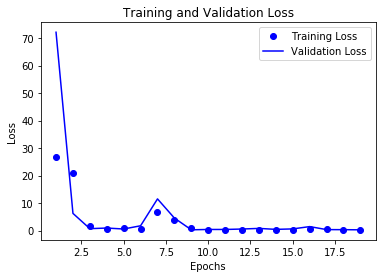

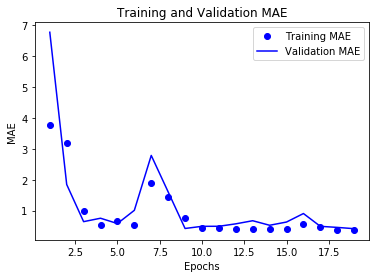

In [43]:
create_val_plot(history)

In [44]:
model_metrics = model.evaluate(val_gen, batch_size=batch_size, steps=val_steps)
model_mae = model_metrics[1]
print('Model MAE: ', model_mae)

108/108 [==============================] - 1s 6ms/step - loss: 0.2657 - mae: 0.4144
Model MAE:  0.414420485496521


With a MAE of 0.41442, the simple machine learning model does not outperform the non-machine-learning baseline, which justifies further experimentation with more complicated neural networks. It is interesting that the model does not appear to be overfitting.

## 6. Developing a Recurrent Neural Network

Since a densely connected neural network cannot outperform the non-machine-learning baseline, a more suitable network type for time series problems, a recurrent neural network (RNN), will be experimented with. To start, a model using Long Short Term Memory (LSTM) units is built and trained:

In [45]:

model = Sequential()
model.add(layers.LSTM(32, activation='relu', input_shape=(input_length, train_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6656      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model_compile_fit(model=model, 
                            data=train_gen, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=20, 
                            validation_data=val_gen, 
                            validation_steps=val_steps,
                            early_stopping=True,
                            patience=10, 
                            min_delta=0.2)

Epoch 1/20
382/382 [==============================] - 20s 52ms/step - loss: 4.4392 - mae: 0.5924 - val_loss: 0.1785 - val_mae: 0.3310
Epoch 2/20
382/382 [==============================] - 19s 50ms/step - loss: 0.1681 - mae: 0.3186 - val_loss: 0.1531 - val_mae: 0.3044
Epoch 3/20
382/382 [==============================] - 20s 52ms/step - loss: 0.1487 - mae: 0.2991 - val_loss: 0.1406 - val_mae: 0.2946
Epoch 4/20
382/382 [==============================] - 19s 50ms/step - loss: 0.1373 - mae: 0.2894 - val_loss: 0.1377 - val_mae: 0.2921
Epoch 5/20
382/382 [==============================] - 21s 55ms/step - loss: 0.1328 - mae: 0.2842 - val_loss: 0.1363 - val_mae: 0.2911
Epoch 6/20
382/382 [==============================] - 20s 52ms/step - loss: 0.1299 - mae: 0.2810 - val_loss: 0.1353 - val_mae: 0.2904
Epoch 7/20
382/382 [==============================] - 23s 59ms/step - loss: 0.1280 - mae: 0.2789 - val_loss: 0.1347 - val_mae: 0.2899
Epoch 8/20
382/382 [==============================] - 20s 53ms

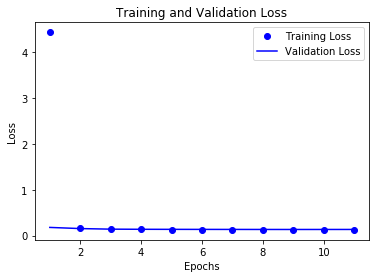

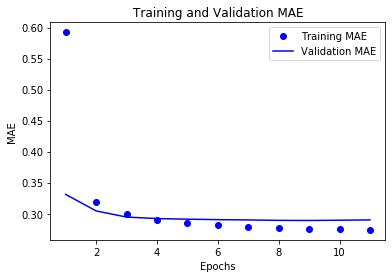

In [47]:
create_val_plot(history)

In [48]:
model_metrics = model.evaluate(val_gen, batch_size=batch_size, steps=val_steps)
model_mae = model_metrics[1]
print('Model MAE: ', model_mae)

108/108 [==============================] - 1s 14ms/step - loss: 0.1341 - mae: 0.2900
Model MAE:  0.28997233510017395


Using LSTM units in a RNN has improved the MAE from 0.41442 to 0.28997, so use of a more complicated model is appropriate in this case. From the plots for the training and validation loss and MAE, it does appear that there is a performance limit that is being approached, as further training epochs do not decrease the loss/improve the MAE. 

Final improvements to the RNN are discussed in the next section.

## 7. Improving Model Performance

One final improvement to the RNN developed in Section 6 is to add recurrent dropout, with the hope that it will help the model be able to generalize to unseen data in the test set.

### 7.1 Final Model Configuration

The following code creates and trains the same RNN as before, with recurrent dropout included:

In [49]:
model = Sequential()
model.add(layers.LSTM(32, activation='relu', input_shape=(input_length, train_data.shape[-1]), 
                      dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6656      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model_compile_fit(model=model, 
                            data=train_gen, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=40, 
                            validation_data=val_gen, 
                            validation_steps=val_steps,
                            early_stopping=True,
                            patience=10, 
                            min_delta=0.2)

Epoch 1/40
382/382 [==============================] - 42s 111ms/step - loss: 0.4552 - mae: 0.4533 - val_loss: 0.1521 - val_mae: 0.3073
Epoch 2/40
382/382 [==============================] - 40s 106ms/step - loss: 0.1671 - mae: 0.3200 - val_loss: 0.1362 - val_mae: 0.2909
Epoch 3/40
382/382 [==============================] - 42s 109ms/step - loss: 0.1514 - mae: 0.3045 - val_loss: 0.1330 - val_mae: 0.2881
Epoch 4/40
382/382 [==============================] - 46s 121ms/step - loss: 0.1468 - mae: 0.2992 - val_loss: 0.1309 - val_mae: 0.2860
Epoch 5/40
382/382 [==============================] - 43s 113ms/step - loss: 0.1434 - mae: 0.2961 - val_loss: 0.1303 - val_mae: 0.2856
Epoch 6/40
382/382 [==============================] - 44s 116ms/step - loss: 0.1411 - mae: 0.2931 - val_loss: 0.1278 - val_mae: 0.2825
Epoch 7/40
382/382 [==============================] - 42s 110ms/step - loss: 0.1400 - mae: 0.2918 - val_loss: 0.1285 - val_mae: 0.2837
Epoch 8/40
382/382 [==============================] - 4

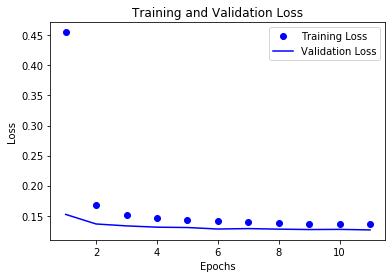

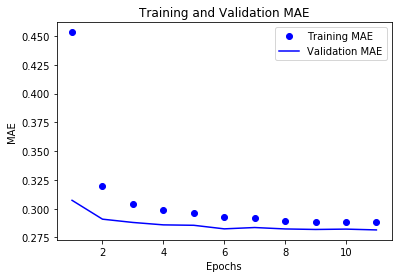

In [51]:
create_val_plot(history)

In [52]:
model_metrics = model.evaluate(val_gen, batch_size=batch_size, steps=val_steps)
model_mae = model_metrics[1]
print('Model MAE: ', model_mae)

108/108 [==============================] - 2s 14ms/step - loss: 0.1263 - mae: 0.2816
Model MAE:  0.28158628940582275


Including dropout gives a small improvement in the MAE, from 0.28997 to 0.28159.

### 7.2 Training Final Model Configation on Complete Training Data

The final model configuration is now trained on the "complete" training data, which is just the combination of the previously defined training and validation sets. The validation set is added to the end of the training set, to preserve the order of time within the data, and for the same reason the data is not shuffled.

The code below creates the complete training data `train_data_full`, defines a new generator `train_full_gen` to draw from `train_data_full`, and updates the `steps_per_epoch` as the complete training data set is now larger.

In [70]:
df_train_full = df_train.append(df_val)
train_data_full = df_train_full.values
print('train_data_full shape: ', train_data_full.shape)

input_length = 5 * 24
offset = 24
step = 1

batch_size = 128

train_full_gen = data_generator(train_data_full, 
                                input_length=input_length, 
                                offset=offset, 
                                batch_size=batch_size, 
                                step=step)

steps_per_epoch = (num_train_samples + num_val_samples - input_length) // batch_size
print('steps_per_epoch = ', steps_per_epoch)

train_data_full shape:  (63067, 19)
steps_per_epoch =  491


The following code builds the final model (`model_final`) and then trains the model for a full 20 epochs, without early stopping:

In [72]:
model_final = Sequential()
model_final.add(layers.LSTM(32, activation='relu', input_shape=(input_length, train_data_full.shape[-1]), 
                      dropout=0.2, recurrent_dropout=0.2))
model_final.add(layers.Dense(1))

model_final.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                6656      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [74]:
model_final.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_full = model_final.fit(train_full_gen, 
                               steps_per_epoch=steps_per_epoch, 
                               epochs=20, 
                               validation_data=test_gen, 
                               validation_steps=test_steps)

Epoch 1/20
491/491 [==============================] - 50s 102ms/step - loss: 0.1563 - mae: 0.3083 - val_loss: 0.0989 - val_mae: 0.2497
Epoch 2/20
491/491 [==============================] - 48s 98ms/step - loss: 0.1433 - mae: 0.2957 - val_loss: 0.0961 - val_mae: 0.2452
Epoch 3/20
491/491 [==============================] - 47s 96ms/step - loss: 0.1388 - mae: 0.2909 - val_loss: 0.0974 - val_mae: 0.2475
Epoch 4/20
491/491 [==============================] - 48s 97ms/step - loss: 0.1360 - mae: 0.2875 - val_loss: 0.0966 - val_mae: 0.2459
Epoch 5/20
491/491 [==============================] - 52s 107ms/step - loss: 0.1353 - mae: 0.2875 - val_loss: 0.0959 - val_mae: 0.2454
Epoch 6/20
491/491 [==============================] - 52s 106ms/step - loss: 0.1330 - mae: 0.2845 - val_loss: 0.0960 - val_mae: 0.2454
Epoch 7/20
491/491 [==============================] - 65s 132ms/step - loss: 0.1325 - mae: 0.2839 - val_loss: 0.0961 - val_mae: 0.2453
Epoch 8/20
491/491 [==============================] - 54s 

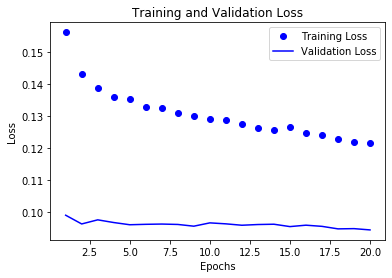

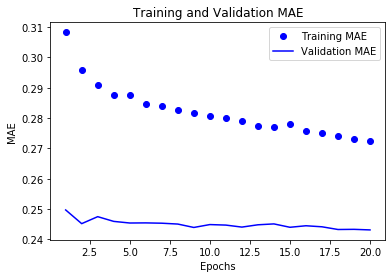

In [75]:
create_val_plot(history_full)

The final model is evaluated on the test dataset:

In [89]:
model_test_metrics = model_final.evaluate(test_gen, batch_size=batch_size, steps=test_steps)
model_test_mae = model_test_metrics[1]
print('Model Test MAE: ', model_test_mae)

53/53 [==============================] - 1s 12ms/step - loss: 0.0943 - mae: 0.2431
Model Test MAE:  0.24313518404960632


In [295]:
model_test_mae_degC = model_test_mae * df_train_std[1]

print('Model Test MAE (deg C, actual): ', round(model_test_mae_degC, 2))

Model Test MAE (deg C, actual):  2.1


The final model configuration has a MAE of 0.24314 on the test set, which is an improvement over the non machine learning baseline of 0.31880. Since the datasets were normalized, a MAE of 0.24314 corresponds to an actual MAE of 2.1 degrees Celsius, which seems large given that the target temperature is only 24 hours in the future. 

In the next section, these results are visualized to gain a better understanding of the final models behaviour.

## 8. Visualizing Results

In order to visualize the results of the model, the following steps are taken:

1. Draw a single batch of input features and target temperature data from the test set, and use with the final model developed to make temperature predictions
2. Extract the input temperature values out of the single batch of data
3. "Un-standardize" the data to present the temperature values and predictions in actual degrees Celsius
4. Plot the input temperature data, target temperature, and predicted temperature on a continous time scale, with hour 0 marking the beginning of the data batch

The following code carries out the above steps:


**Step 1**

A single batch of sample/target pairs is drawn from the test set, and then the final model is used to make predictions for the temperature.

In [263]:
samples, targets = next(test_gen)

predictions = model_final.predict(samples)

In [264]:
predictions.shape

(128, 1)

In [265]:
targets.shape

(128,)

**Step 2**

A numpy array named `samples_temps` is initialized, and then the `samples` array is looped over, storing the input temperature values in `samples_temps`.

In [266]:
samples_temps = np.zeros((samples.shape[0], samples.shape[1]))

for i in range(0, samples.shape[0]):
    for j in range(0, samples.shape[1]):
        samples_temps[i][j] = samples[i][j][1]

In [267]:
samples_temps.shape

(128, 120)

**Step 3**

The temperature values in `samples_temps`, `targets` and `predictions` is un-standardized by performing the reverse procedure as in Section 4.3: multiplying by the standard deviation and adding the mean:

In [268]:
samples_temps = samples_temps * df_train_std[1] + df_train_mean[1]
targets = targets * df_train_std[1] + df_train_mean[1]
predictions = predictions * df_train_std[1] + df_train_mean[1]

**Step 4**

The following code plots consecutive input temperature sequences and their corresponding target temperatures that were drawn from the test set in Step 1, along with the predicted temperatures from the final model. 

The input temperatures are plotted from the beginning of the batch, so the first input temperature sequence starts at hour 0. Since the offset is equal to 24 hours, each subsequent sequence will begin 24 hours in the future, as indicated on the plot x-axes.

The plots below illustrate how the model is input sequence data of length `input_length`, with a corresponding target temperature that occurs `offset` hours in the future (recall `input_length` is 120 hours and `offset` is 24 hours). The model has learned from patterns between the input sequences and their targets to be able to make a prediction for the temperature `offset` hours after the end of each input sequence.

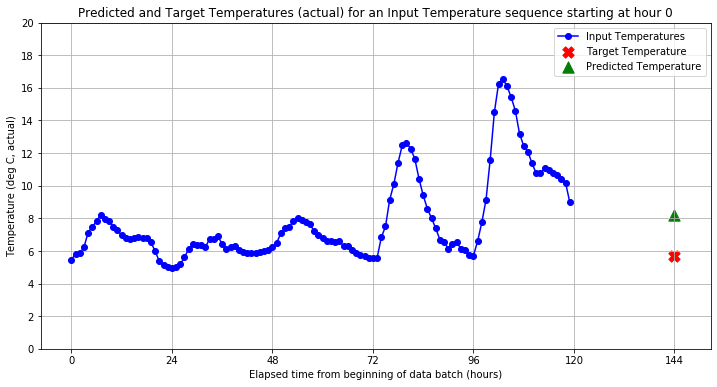

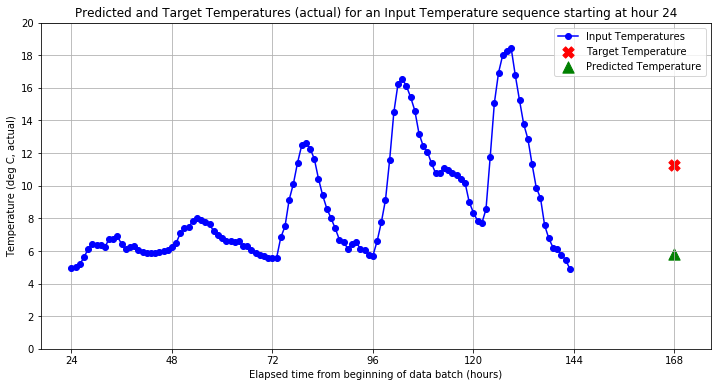

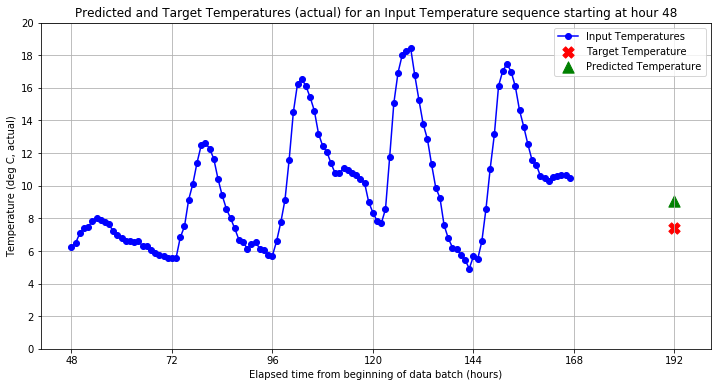

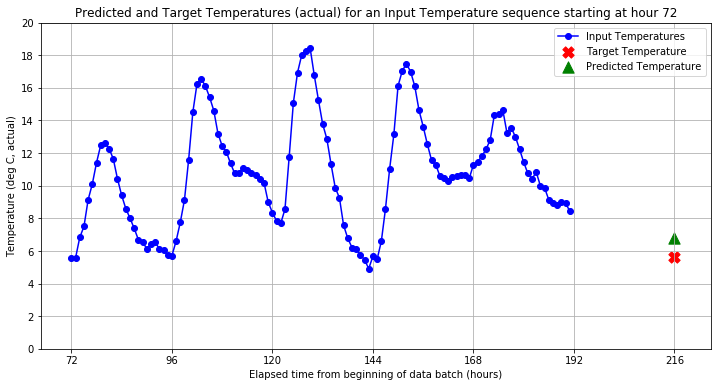

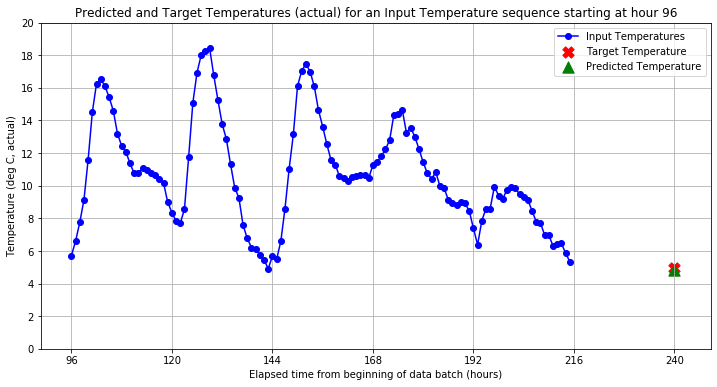

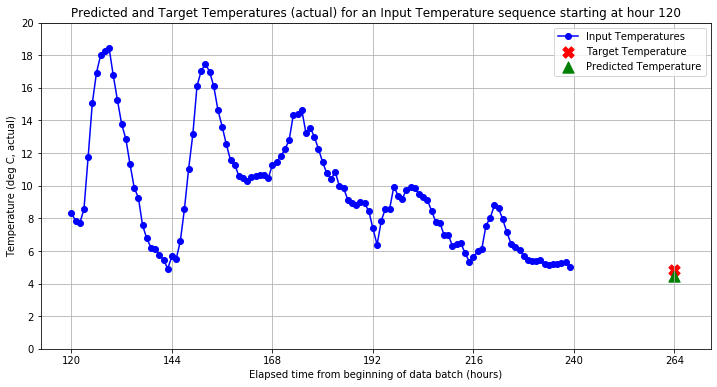

In [287]:

plot_indices = np.arange(0, input_length+1, offset)

for i in range(0, len(plot_indices)):
    
    index = plot_indices[i]
    plt.figure(i, figsize=(12,6))
    plt.plot(np.arange(index, input_length+index), samples_temps[index], marker='o', c='b', label='Input Temperatures')
    plt.scatter(x=index+input_length+offset, y=targets[index], marker='X', c='r', s=128, label='Target Temperature')
    plt.scatter(x=index+input_length+offset, y=predictions[index], marker='^', c='g', s=128, label='Predicted Temperature')

    plt.title('Predicted and Target Temperatures (actual) for an Input Temperature sequence starting at hour ' + str(index))
    plt.xlabel('Elapsed time from beginning of data batch (hours)')
    plt.xticks(np.arange(index, index+input_length+offset+1, offset))
    plt.ylabel('Temperature (deg C, actual)')
    plt.yticks(np.arange(0,20+1,2))
    plt.legend()
    plt.grid();    

In [294]:
sample_batch_mae_degC = np.mean(np.abs(predictions - targets))

print('Sample Batch MAE (deg C, actual): ', round(sample_batch_mae_degC, 2))

Sample Batch MAE (deg C, actual):  3.74


Although the six plots shown above are hardly representative of the entire test set, they do show that the model can make predictions very close to the target, but can also make predictions that are 2-6 deg C in error. A quick check of the MAE on the sample batch used for visualization gives a value of 3.74 deg C, which is close to the value for the whole test set (2.1 deg C).

A comparison of the plots for the input sequences starting at hour 0 or hour 24 vs. hour 96 or hour 120 show that the model provides more accurate predictions when the entire input sequence trends in the same direction (increasing or decreasing temperature) instead of having the end of the sequence increase or decrease, which makes sense intuitively since the model is trying to learn from patterns in the data. The observation that the model may learn better from more gradual changes in temperature suggests that the `input_length`, `offset` and `step` parameters are important to select  carefully in order to obtain the most accurate temperature predictions.

## 9. Conclusion

A recurrent neural network using one LSTM layer and recurrent dropout has been developed to predict the temperature 24 hours in the future, based on 120 hours of past weather data, with a mean absolute error of 2.1 degrees Celsius.

## 10. References

Inspiration for this notebook came from the following sources:

* Deep Learning with Python, Francois Chollet, 2018

* Time series forecasting  |  TensorFlow Core, TensorFlow Tutorial, available at: https://www.tensorflow.org/tutorials/structured_data/time_series

* Timeseries forecasting for weather prediction, Keras Documentation, available at: https://keras.io/examples/timeseries/timeseries_weather_forecasting/

